<a href="https://colab.research.google.com/github/9-coding/ComputerVision_TeamProject/blob/main/ActiveLearning2/ActiveLearning2_modelCompare_effi_b5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
# 각자 환경에서 이 부분만 변경하여 사용하면 됩니다.
os.chdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50')
print(os.getcwd())



Mounted at /content/gdrive/
/content/gdrive/MyDrive/CUB_200_2011_repackage_class50


In [2]:
# !pip uninstall wandb

In [3]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [4]:
!wandb login f9fc6c65de4904021a59f4c8c60b90961f6ec1fb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import random

## wandb ###
import wandb
wandb.init(project='ActiveLearning2_modelCompare')

'''def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)'''


### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Custom Dataset ###
class CUB2011(Dataset):
    def __init__(self, transform, mode='train'):
        self.transform = transform
        self.mode = mode
        self.image_folder = os.listdir(f'./datasets/{mode}')

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = Image.open(os.path.join('./datasets', self.mode, img_path)).convert('RGB')
        img = self.transform(img)
        label = int(img_path.split('_')[-1].split('.')[0])
        return (img, label)

wandb: Currently logged in as: kdy1021 (computervisionactivelearning). Use `wandb login --relogin` to force relogin


cuda


In [6]:
### Data Augmentation ###
def transforms_func(transform):
  return transforms.Compose([
    transforms.Resize((448, 448)),
    transform,
    transforms.ToTensor(),
])

def transforms_resize_func(resize):
  return transforms.Compose([
    resize,
    transforms.ToTensor(),
])

ROTATION_DEGREE = 30
zoom_scale = (0.8, 1.2)
transforms_rotation = transforms_func(transforms.RandomRotation(degrees=ROTATION_DEGREE))
transforms_horizontal_flip = transforms_func(transforms.RandomHorizontalFlip(p=1.0))
transforms_zoom = transforms_func(transforms.RandomResizedCrop(448, scale=zoom_scale))

transforms_train = transforms_resize_func(transforms.Resize((448, 448)))
transforms_valtest = transforms_resize_func(transforms.Resize((448, 448)))
transforms_random_resized_crop = transforms_resize_func(transforms.RandomResizedCrop(448, scale=(0.8, 1.0)))

In [7]:
BATCH_SIZE = 10
EPOCH = 20
lr = 0.1

train_set = CUB2011(mode='train', transform=transforms_train)
train_set_rotation = CUB2011(mode='train', transform=transforms_rotation)
train_set_horizontal_flip = CUB2011(mode='train', transform=transforms_horizontal_flip)
train_set_randomcrop =  CUB2011(mode='train', transform=transforms_random_resized_crop)
train_set_zoom = CUB2011(mode='train', transform=transforms_zoom)

combined_train_set = ConcatDataset([train_set, train_set_rotation, train_set_horizontal_flip, train_set_zoom])

val_set = CUB2011(mode='valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)

train_loader = DataLoader(combined_train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b9167932d58e7b148f73c21b92e5c5c5d5e8520bcb086d27bf246156d0ed2b8b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [9]:
import torchsummary
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=50)
model = model.eval().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=lr)

print("EfficientNet-b5")
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 169MB/s]


Loaded pretrained weights for efficientnet-b5
EfficientNet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
  

In [10]:
### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        train_loss = F.cross_entropy(output, target).to(DEVICE)
        train_loss.backward()
        optimizer.step()

        if i % 30 == 0:
            print(f'Train Epoch {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
    return train_loss

def evaluate(model, val_loader):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image, target = image.to(DEVICE), target.to(DEVICE)
            output = model(image)
            eval_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        eval_loss /= len(val_loader.dataset)
        eval_accuracy = 100 * correct / len(val_loader.dataset)
        return eval_loss, eval_accuracy

Train Epoch 0 [0/944]	Loss: 3.909747
Train Epoch 0 [30/944]	Loss: 3.292144
Train Epoch 0 [60/944]	Loss: 2.501945
Train Epoch 0 [90/944]	Loss: 1.887408
Train Epoch 0 [120/944]	Loss: 1.337461
Train Epoch 0 [150/944]	Loss: 0.828616
Train Epoch 0 [180/944]	Loss: 0.386615
Train Epoch 0 [210/944]	Loss: 1.041044
Train Epoch 0 [240/944]	Loss: 0.332978
Train Epoch 0 [270/944]	Loss: 0.536771
Train Epoch 0 [300/944]	Loss: 0.141778
Train Epoch 0 [330/944]	Loss: 0.117958
Train Epoch 0 [360/944]	Loss: 0.168951
Train Epoch 0 [390/944]	Loss: 0.374316
Train Epoch 0 [420/944]	Loss: 0.332026
Train Epoch 0 [450/944]	Loss: 0.568876
Train Epoch 0 [480/944]	Loss: 0.744690
Train Epoch 0 [510/944]	Loss: 0.483029
Train Epoch 0 [540/944]	Loss: 0.559192
Train Epoch 0 [570/944]	Loss: 0.211292
Train Epoch 0 [600/944]	Loss: 0.359172
Train Epoch 0 [630/944]	Loss: 0.079757
Train Epoch 0 [660/944]	Loss: 0.176242
Train Epoch 0 [690/944]	Loss: 0.257824
Train Epoch 0 [720/944]	Loss: 0.118651
Train Epoch 0 [750/944]	Loss: 

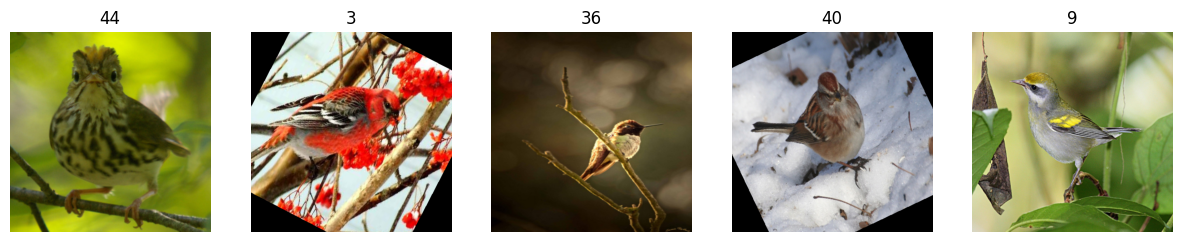

Epoch 0
Train Loss: 0.0088, Validation Loss: 0.2068, Validation Accuracy: 94.93%

Train Epoch 1 [0/944]	Loss: 0.069411
Train Epoch 1 [30/944]	Loss: 0.046234
Train Epoch 1 [60/944]	Loss: 0.026466
Train Epoch 1 [90/944]	Loss: 0.014635
Train Epoch 1 [120/944]	Loss: 0.031699
Train Epoch 1 [150/944]	Loss: 0.045232
Train Epoch 1 [180/944]	Loss: 0.560338
Train Epoch 1 [210/944]	Loss: 0.002455
Train Epoch 1 [240/944]	Loss: 0.021720
Train Epoch 1 [270/944]	Loss: 0.003450
Train Epoch 1 [300/944]	Loss: 0.004046
Train Epoch 1 [330/944]	Loss: 0.036594
Train Epoch 1 [360/944]	Loss: 0.005931
Train Epoch 1 [390/944]	Loss: 0.008784
Train Epoch 1 [420/944]	Loss: 0.006642
Train Epoch 1 [450/944]	Loss: 0.022097
Train Epoch 1 [480/944]	Loss: 0.030166
Train Epoch 1 [510/944]	Loss: 0.003149
Train Epoch 1 [540/944]	Loss: 0.083519
Train Epoch 1 [570/944]	Loss: 0.009422
Train Epoch 1 [600/944]	Loss: 0.150164
Train Epoch 1 [630/944]	Loss: 0.016486
Train Epoch 1 [660/944]	Loss: 0.034597
Train Epoch 1 [690/944]	Lo

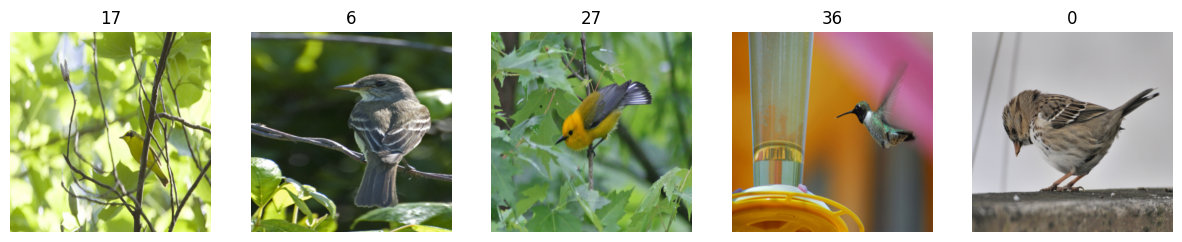

Epoch 1
Train Loss: 0.0540, Validation Loss: 0.1771, Validation Accuracy: 94.93%

Train Epoch 2 [0/944]	Loss: 0.003559
Train Epoch 2 [30/944]	Loss: 0.008803
Train Epoch 2 [60/944]	Loss: 0.004634
Train Epoch 2 [90/944]	Loss: 0.029608
Train Epoch 2 [120/944]	Loss: 0.034609
Train Epoch 2 [150/944]	Loss: 0.015948
Train Epoch 2 [180/944]	Loss: 0.003796
Train Epoch 2 [210/944]	Loss: 0.003746
Train Epoch 2 [240/944]	Loss: 0.006406
Train Epoch 2 [270/944]	Loss: 0.010429
Train Epoch 2 [300/944]	Loss: 0.008389
Train Epoch 2 [330/944]	Loss: 0.006954
Train Epoch 2 [360/944]	Loss: 0.003399
Train Epoch 2 [390/944]	Loss: 0.003157
Train Epoch 2 [420/944]	Loss: 0.002008
Train Epoch 2 [450/944]	Loss: 0.013498
Train Epoch 2 [480/944]	Loss: 0.001419
Train Epoch 2 [510/944]	Loss: 0.006393
Train Epoch 2 [540/944]	Loss: 0.014889
Train Epoch 2 [570/944]	Loss: 0.012804
Train Epoch 2 [600/944]	Loss: 0.002984
Train Epoch 2 [630/944]	Loss: 0.017263
Train Epoch 2 [660/944]	Loss: 0.004785
Train Epoch 2 [690/944]	Lo

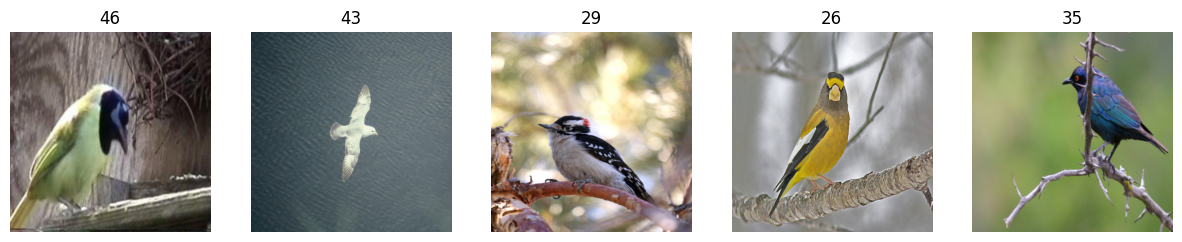

Epoch 2
Train Loss: 0.0089, Validation Loss: 0.1869, Validation Accuracy: 95.61%

Train Epoch 3 [0/944]	Loss: 0.003356
Train Epoch 3 [30/944]	Loss: 0.005259
Train Epoch 3 [60/944]	Loss: 0.009520
Train Epoch 3 [90/944]	Loss: 0.003230
Train Epoch 3 [120/944]	Loss: 0.002361
Train Epoch 3 [150/944]	Loss: 0.002695
Train Epoch 3 [180/944]	Loss: 0.005048
Train Epoch 3 [210/944]	Loss: 0.000796
Train Epoch 3 [240/944]	Loss: 0.002396
Train Epoch 3 [270/944]	Loss: 0.024795
Train Epoch 3 [300/944]	Loss: 0.042774
Train Epoch 3 [330/944]	Loss: 0.002349
Train Epoch 3 [360/944]	Loss: 0.005383
Train Epoch 3 [390/944]	Loss: 0.001091
Train Epoch 3 [420/944]	Loss: 0.000580
Train Epoch 3 [450/944]	Loss: 0.003480
Train Epoch 3 [480/944]	Loss: 0.007398
Train Epoch 3 [510/944]	Loss: 0.010156
Train Epoch 3 [540/944]	Loss: 0.041944
Train Epoch 3 [570/944]	Loss: 0.026011
Train Epoch 3 [600/944]	Loss: 0.003431
Train Epoch 3 [630/944]	Loss: 0.005877
Train Epoch 3 [660/944]	Loss: 0.010336
Train Epoch 3 [690/944]	Lo

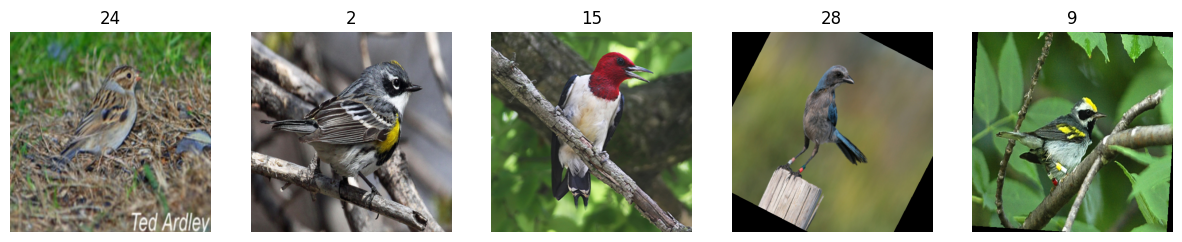

Epoch 3
Train Loss: 0.0012, Validation Loss: 0.2456, Validation Accuracy: 94.26%

Train Epoch 4 [0/944]	Loss: 0.005877
Train Epoch 4 [30/944]	Loss: 0.003271
Train Epoch 4 [60/944]	Loss: 0.024987
Train Epoch 4 [90/944]	Loss: 0.001464
Train Epoch 4 [120/944]	Loss: 0.014056
Train Epoch 4 [150/944]	Loss: 0.006697
Train Epoch 4 [180/944]	Loss: 0.002716
Train Epoch 4 [210/944]	Loss: 0.016708
Train Epoch 4 [240/944]	Loss: 0.003028
Train Epoch 4 [270/944]	Loss: 0.001762
Train Epoch 4 [300/944]	Loss: 0.001720
Train Epoch 4 [330/944]	Loss: 0.001494
Train Epoch 4 [360/944]	Loss: 0.006745
Train Epoch 4 [390/944]	Loss: 0.003351
Train Epoch 4 [420/944]	Loss: 0.001790
Train Epoch 4 [450/944]	Loss: 0.004415
Train Epoch 4 [480/944]	Loss: 0.013263
Train Epoch 4 [510/944]	Loss: 0.025757
Train Epoch 4 [540/944]	Loss: 0.001871
Train Epoch 4 [570/944]	Loss: 0.003348
Train Epoch 4 [600/944]	Loss: 0.001577
Train Epoch 4 [630/944]	Loss: 0.001051
Train Epoch 4 [660/944]	Loss: 0.268733
Train Epoch 4 [690/944]	Lo

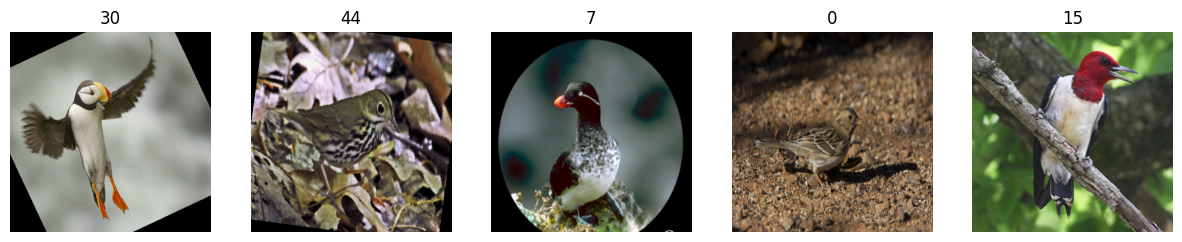

Epoch 4
Train Loss: 0.0033, Validation Loss: 0.2097, Validation Accuracy: 95.95%

Train Epoch 5 [0/944]	Loss: 0.001207
Train Epoch 5 [30/944]	Loss: 0.000871
Train Epoch 5 [60/944]	Loss: 0.005265
Train Epoch 5 [90/944]	Loss: 0.003502
Train Epoch 5 [120/944]	Loss: 0.000490
Train Epoch 5 [150/944]	Loss: 0.005230
Train Epoch 5 [180/944]	Loss: 0.002588
Train Epoch 5 [210/944]	Loss: 0.127092
Train Epoch 5 [240/944]	Loss: 0.002751
Train Epoch 5 [270/944]	Loss: 0.041892
Train Epoch 5 [300/944]	Loss: 0.006877
Train Epoch 5 [330/944]	Loss: 0.003173
Train Epoch 5 [360/944]	Loss: 0.000631
Train Epoch 5 [390/944]	Loss: 0.009417
Train Epoch 5 [420/944]	Loss: 0.002897
Train Epoch 5 [450/944]	Loss: 0.001408
Train Epoch 5 [480/944]	Loss: 0.001148
Train Epoch 5 [510/944]	Loss: 0.006395
Train Epoch 5 [540/944]	Loss: 0.003286
Train Epoch 5 [570/944]	Loss: 0.000440
Train Epoch 5 [600/944]	Loss: 0.000819
Train Epoch 5 [630/944]	Loss: 0.000318
Train Epoch 5 [660/944]	Loss: 0.000108
Train Epoch 5 [690/944]	Lo

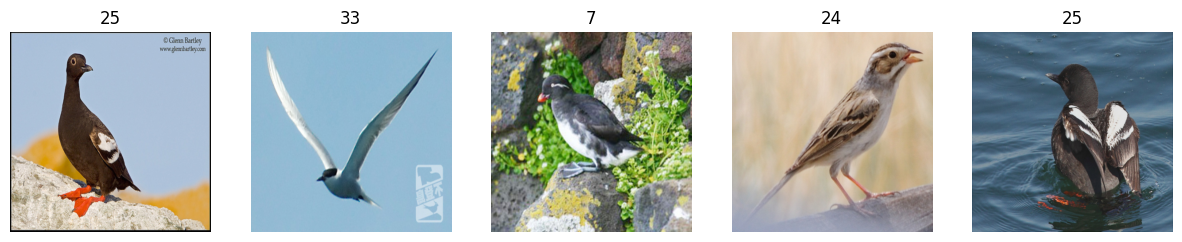

Epoch 5
Train Loss: 0.0028, Validation Loss: 0.1807, Validation Accuracy: 95.27%

Train Epoch 6 [0/944]	Loss: 0.000330
Train Epoch 6 [30/944]	Loss: 0.000422
Train Epoch 6 [60/944]	Loss: 0.001695
Train Epoch 6 [90/944]	Loss: 0.000306
Train Epoch 6 [120/944]	Loss: 0.000540
Train Epoch 6 [150/944]	Loss: 0.000219
Train Epoch 6 [180/944]	Loss: 0.000205
Train Epoch 6 [210/944]	Loss: 0.000289
Train Epoch 6 [240/944]	Loss: 0.024446
Train Epoch 6 [270/944]	Loss: 0.001070
Train Epoch 6 [300/944]	Loss: 0.045778
Train Epoch 6 [330/944]	Loss: 0.002309
Train Epoch 6 [360/944]	Loss: 0.013567
Train Epoch 6 [390/944]	Loss: 0.000667
Train Epoch 6 [420/944]	Loss: 0.002029
Train Epoch 6 [450/944]	Loss: 0.071094
Train Epoch 6 [480/944]	Loss: 0.001818
Train Epoch 6 [510/944]	Loss: 0.010876
Train Epoch 6 [540/944]	Loss: 0.008596
Train Epoch 6 [570/944]	Loss: 0.000123
Train Epoch 6 [600/944]	Loss: 0.009200
Train Epoch 6 [630/944]	Loss: 0.001630
Train Epoch 6 [660/944]	Loss: 0.004015
Train Epoch 6 [690/944]	Lo

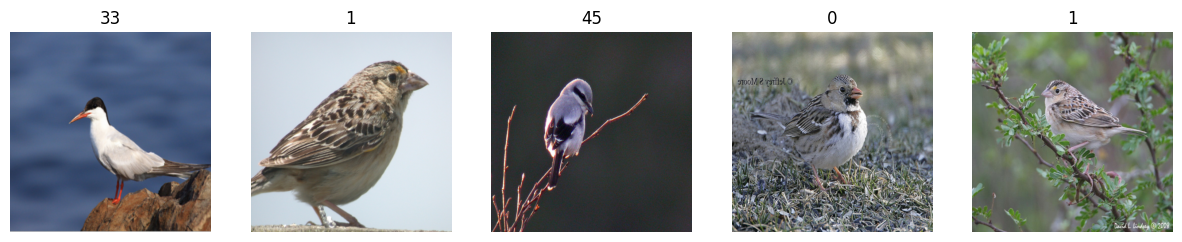

Epoch 6
Train Loss: 0.0011, Validation Loss: 0.1728, Validation Accuracy: 94.93%

Train Epoch 7 [0/944]	Loss: 0.002124
Train Epoch 7 [30/944]	Loss: 0.001192
Train Epoch 7 [60/944]	Loss: 0.003822
Train Epoch 7 [90/944]	Loss: 0.001780
Train Epoch 7 [120/944]	Loss: 0.000311
Train Epoch 7 [150/944]	Loss: 0.003305
Train Epoch 7 [180/944]	Loss: 0.000818
Train Epoch 7 [210/944]	Loss: 0.000259
Train Epoch 7 [240/944]	Loss: 0.001412
Train Epoch 7 [270/944]	Loss: 0.001059
Train Epoch 7 [300/944]	Loss: 0.000304
Train Epoch 7 [330/944]	Loss: 0.000097
Train Epoch 7 [360/944]	Loss: 0.002815
Train Epoch 7 [390/944]	Loss: 0.002142
Train Epoch 7 [420/944]	Loss: 0.000909
Train Epoch 7 [450/944]	Loss: 0.000627
Train Epoch 7 [480/944]	Loss: 0.000822
Train Epoch 7 [510/944]	Loss: 0.000053
Train Epoch 7 [540/944]	Loss: 0.003768
Train Epoch 7 [570/944]	Loss: 0.000469
Train Epoch 7 [600/944]	Loss: 0.000654
Train Epoch 7 [630/944]	Loss: 0.009361
Train Epoch 7 [660/944]	Loss: 0.003724
Train Epoch 7 [690/944]	Lo

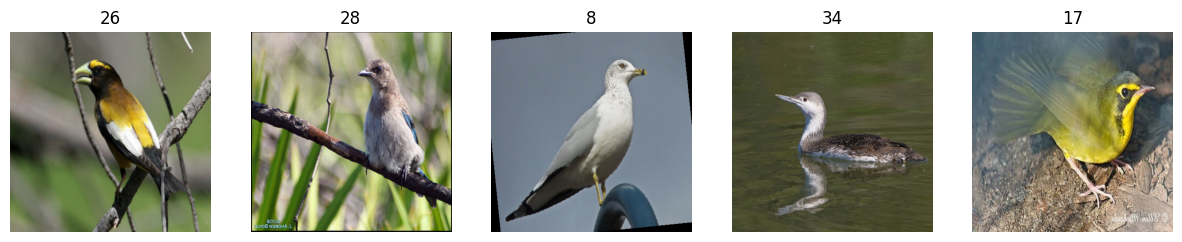

Epoch 7
Train Loss: 0.0007, Validation Loss: 0.1858, Validation Accuracy: 95.61%

Train Epoch 8 [0/944]	Loss: 0.001967
Train Epoch 8 [30/944]	Loss: 0.001398
Train Epoch 8 [60/944]	Loss: 0.000274
Train Epoch 8 [90/944]	Loss: 0.000685
Train Epoch 8 [120/944]	Loss: 0.001109
Train Epoch 8 [150/944]	Loss: 0.000922
Train Epoch 8 [180/944]	Loss: 0.001178
Train Epoch 8 [210/944]	Loss: 0.000695
Train Epoch 8 [240/944]	Loss: 0.011124
Train Epoch 8 [270/944]	Loss: 0.000677
Train Epoch 8 [300/944]	Loss: 0.002585
Train Epoch 8 [330/944]	Loss: 0.001475
Train Epoch 8 [360/944]	Loss: 0.000117
Train Epoch 8 [390/944]	Loss: 0.000172
Train Epoch 8 [420/944]	Loss: 0.000437
Train Epoch 8 [450/944]	Loss: 0.000097
Train Epoch 8 [480/944]	Loss: 0.001117
Train Epoch 8 [510/944]	Loss: 0.002197
Train Epoch 8 [540/944]	Loss: 0.000226
Train Epoch 8 [570/944]	Loss: 0.000940
Train Epoch 8 [600/944]	Loss: 0.016055
Train Epoch 8 [630/944]	Loss: 0.002629
Train Epoch 8 [660/944]	Loss: 0.000926
Train Epoch 8 [690/944]	Lo

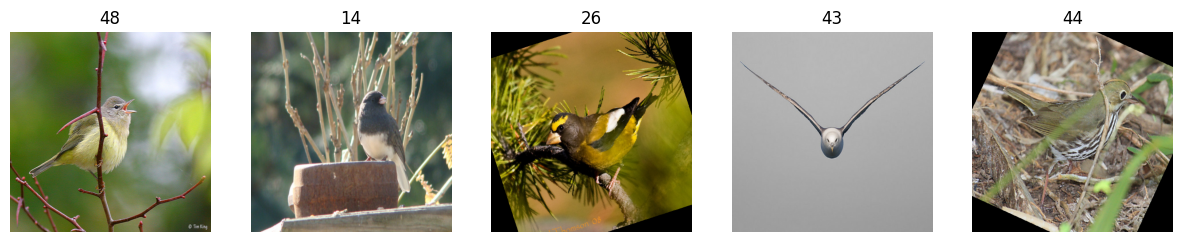

Epoch 8
Train Loss: 0.0002, Validation Loss: 0.1603, Validation Accuracy: 95.61%

Train Epoch 9 [0/944]	Loss: 0.001345
Train Epoch 9 [30/944]	Loss: 0.000471
Train Epoch 9 [60/944]	Loss: 0.000060
Train Epoch 9 [90/944]	Loss: 0.004313
Train Epoch 9 [120/944]	Loss: 0.000942
Train Epoch 9 [150/944]	Loss: 0.001991
Train Epoch 9 [180/944]	Loss: 0.000573
Train Epoch 9 [210/944]	Loss: 0.001384
Train Epoch 9 [240/944]	Loss: 0.000461
Train Epoch 9 [270/944]	Loss: 0.001177
Train Epoch 9 [300/944]	Loss: 0.008235
Train Epoch 9 [330/944]	Loss: 0.001755
Train Epoch 9 [360/944]	Loss: 0.001066
Train Epoch 9 [390/944]	Loss: 0.000105
Train Epoch 9 [420/944]	Loss: 0.000586
Train Epoch 9 [450/944]	Loss: 0.001024
Train Epoch 9 [480/944]	Loss: 0.002716
Train Epoch 9 [510/944]	Loss: 0.000662
Train Epoch 9 [540/944]	Loss: 0.007419
Train Epoch 9 [570/944]	Loss: 0.000509
Train Epoch 9 [600/944]	Loss: 0.001486
Train Epoch 9 [630/944]	Loss: 0.000593
Train Epoch 9 [660/944]	Loss: 0.000589
Train Epoch 9 [690/944]	Lo

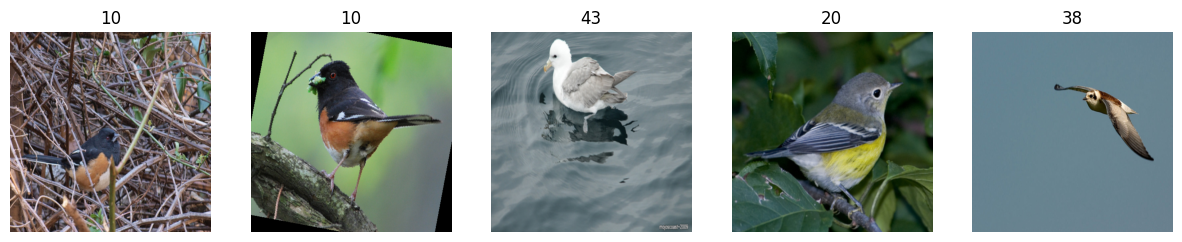

Epoch 9
Train Loss: 0.0007, Validation Loss: 0.1825, Validation Accuracy: 94.93%

Train Epoch 10 [0/944]	Loss: 0.002100
Train Epoch 10 [30/944]	Loss: 0.002448
Train Epoch 10 [60/944]	Loss: 0.000076
Train Epoch 10 [90/944]	Loss: 0.004112
Train Epoch 10 [120/944]	Loss: 0.000397
Train Epoch 10 [150/944]	Loss: 0.001619
Train Epoch 10 [180/944]	Loss: 0.002161
Train Epoch 10 [210/944]	Loss: 0.000298
Train Epoch 10 [240/944]	Loss: 0.002301
Train Epoch 10 [270/944]	Loss: 0.000039
Train Epoch 10 [300/944]	Loss: 0.000160
Train Epoch 10 [330/944]	Loss: 0.000845
Train Epoch 10 [360/944]	Loss: 0.002261
Train Epoch 10 [390/944]	Loss: 0.000641
Train Epoch 10 [420/944]	Loss: 0.001556
Train Epoch 10 [450/944]	Loss: 0.000148
Train Epoch 10 [480/944]	Loss: 0.000985
Train Epoch 10 [510/944]	Loss: 0.001528
Train Epoch 10 [540/944]	Loss: 0.000257
Train Epoch 10 [570/944]	Loss: 0.000321
Train Epoch 10 [600/944]	Loss: 0.000532
Train Epoch 10 [630/944]	Loss: 0.000803
Train Epoch 10 [660/944]	Loss: 0.000140
Tra

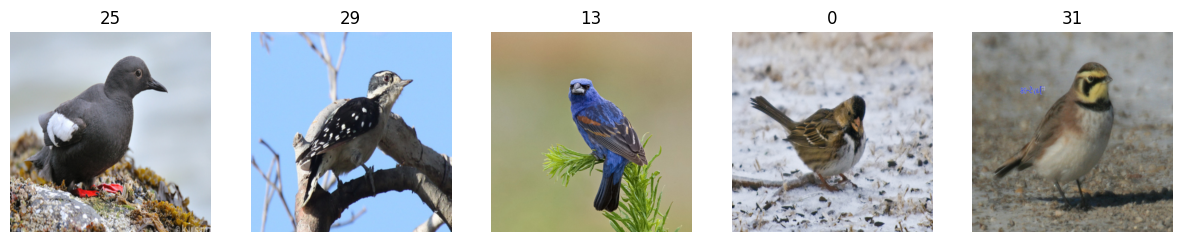

Epoch 10
Train Loss: 0.0008, Validation Loss: 0.1756, Validation Accuracy: 95.27%

Train Epoch 11 [0/944]	Loss: 0.000264
Train Epoch 11 [30/944]	Loss: 0.009151
Train Epoch 11 [60/944]	Loss: 0.000833
Train Epoch 11 [90/944]	Loss: 0.001109
Train Epoch 11 [120/944]	Loss: 0.000597
Train Epoch 11 [150/944]	Loss: 0.001131
Train Epoch 11 [180/944]	Loss: 0.000178
Train Epoch 11 [210/944]	Loss: 0.000118
Train Epoch 11 [240/944]	Loss: 0.005872
Train Epoch 11 [270/944]	Loss: 0.000539
Train Epoch 11 [300/944]	Loss: 0.000356
Train Epoch 11 [330/944]	Loss: 0.000141
Train Epoch 11 [360/944]	Loss: 0.000627
Train Epoch 11 [390/944]	Loss: 0.031642
Train Epoch 11 [420/944]	Loss: 0.001037
Train Epoch 11 [450/944]	Loss: 0.000189
Train Epoch 11 [480/944]	Loss: 0.006939
Train Epoch 11 [510/944]	Loss: 0.001788
Train Epoch 11 [540/944]	Loss: 0.000205
Train Epoch 11 [570/944]	Loss: 0.000460
Train Epoch 11 [600/944]	Loss: 0.000577
Train Epoch 11 [630/944]	Loss: 0.001584
Train Epoch 11 [660/944]	Loss: 0.000734
Tr

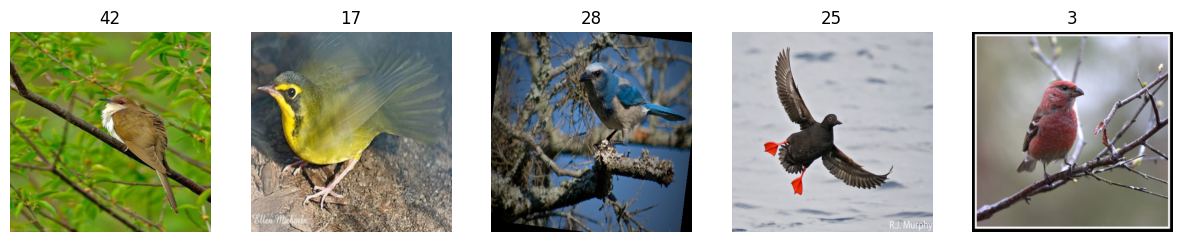

Epoch 11
Train Loss: 0.0002, Validation Loss: 0.2517, Validation Accuracy: 94.59%

Train Epoch 12 [0/944]	Loss: 0.000268
Train Epoch 12 [30/944]	Loss: 0.001062
Train Epoch 12 [60/944]	Loss: 0.001285
Train Epoch 12 [90/944]	Loss: 0.029311
Train Epoch 12 [120/944]	Loss: 0.000355
Train Epoch 12 [150/944]	Loss: 0.001275
Train Epoch 12 [180/944]	Loss: 0.000129
Train Epoch 12 [210/944]	Loss: 0.000511
Train Epoch 12 [240/944]	Loss: 0.000980
Train Epoch 12 [270/944]	Loss: 0.000144
Train Epoch 12 [300/944]	Loss: 0.001222
Train Epoch 12 [330/944]	Loss: 0.001882
Train Epoch 12 [360/944]	Loss: 0.000573
Train Epoch 12 [390/944]	Loss: 0.000623
Train Epoch 12 [420/944]	Loss: 0.001802
Train Epoch 12 [450/944]	Loss: 0.002183
Train Epoch 12 [480/944]	Loss: 0.000097
Train Epoch 12 [510/944]	Loss: 0.000234
Train Epoch 12 [540/944]	Loss: 0.000549
Train Epoch 12 [570/944]	Loss: 0.000717
Train Epoch 12 [600/944]	Loss: 0.000236
Train Epoch 12 [630/944]	Loss: 0.000076
Train Epoch 12 [660/944]	Loss: 0.003827
Tr

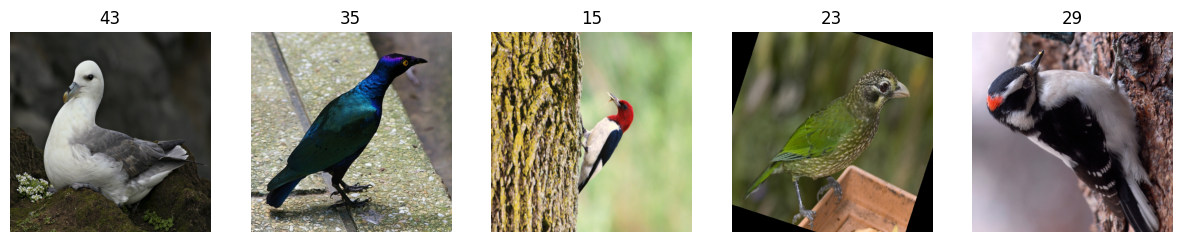

Epoch 12
Train Loss: 0.0004, Validation Loss: 0.2460, Validation Accuracy: 95.27%

Train Epoch 13 [0/944]	Loss: 0.000424
Train Epoch 13 [30/944]	Loss: 0.000170
Train Epoch 13 [60/944]	Loss: 0.000897
Train Epoch 13 [90/944]	Loss: 0.000410
Train Epoch 13 [120/944]	Loss: 0.000280
Train Epoch 13 [150/944]	Loss: 0.000052
Train Epoch 13 [180/944]	Loss: 0.000065
Train Epoch 13 [210/944]	Loss: 0.000440
Train Epoch 13 [240/944]	Loss: 0.000573
Train Epoch 13 [270/944]	Loss: 0.000179
Train Epoch 13 [300/944]	Loss: 0.002379
Train Epoch 13 [330/944]	Loss: 0.002364
Train Epoch 13 [360/944]	Loss: 0.001725
Train Epoch 13 [390/944]	Loss: 0.000033
Train Epoch 13 [420/944]	Loss: 0.000731
Train Epoch 13 [450/944]	Loss: 0.000699
Train Epoch 13 [480/944]	Loss: 0.000150
Train Epoch 13 [510/944]	Loss: 0.000138
Train Epoch 13 [540/944]	Loss: 0.003767
Train Epoch 13 [570/944]	Loss: 0.001734
Train Epoch 13 [600/944]	Loss: 0.000266
Train Epoch 13 [630/944]	Loss: 0.000042
Train Epoch 13 [660/944]	Loss: 0.000042
Tr

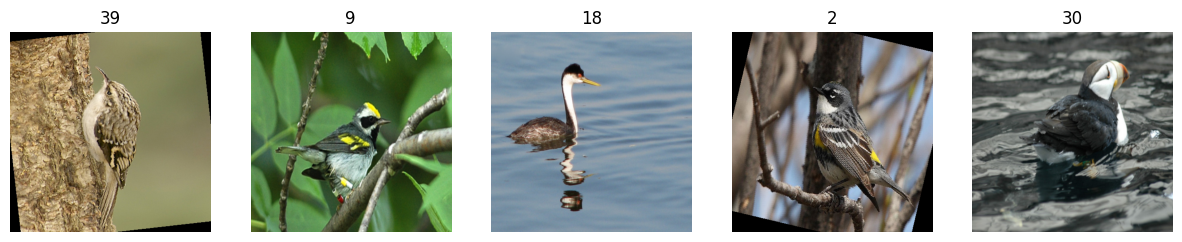

Epoch 13
Train Loss: 0.0001, Validation Loss: 0.2401, Validation Accuracy: 94.59%

Train Epoch 14 [0/944]	Loss: 0.027240
Train Epoch 14 [30/944]	Loss: 0.000273
Train Epoch 14 [60/944]	Loss: 0.000338
Train Epoch 14 [90/944]	Loss: 0.000116
Train Epoch 14 [120/944]	Loss: 0.000088
Train Epoch 14 [150/944]	Loss: 0.000109
Train Epoch 14 [180/944]	Loss: 0.000044
Train Epoch 14 [210/944]	Loss: 0.000218
Train Epoch 14 [240/944]	Loss: 0.000786
Train Epoch 14 [270/944]	Loss: 0.000076
Train Epoch 14 [300/944]	Loss: 0.000203
Train Epoch 14 [330/944]	Loss: 0.000237
Train Epoch 14 [360/944]	Loss: 0.002794
Train Epoch 14 [390/944]	Loss: 0.000159
Train Epoch 14 [420/944]	Loss: 0.001269
Train Epoch 14 [450/944]	Loss: 0.000309
Train Epoch 14 [480/944]	Loss: 0.000105
Train Epoch 14 [510/944]	Loss: 0.004618
Train Epoch 14 [540/944]	Loss: 0.001443
Train Epoch 14 [570/944]	Loss: 0.000083
Train Epoch 14 [600/944]	Loss: 0.000168
Train Epoch 14 [630/944]	Loss: 0.001386
Train Epoch 14 [660/944]	Loss: 0.001857
Tr

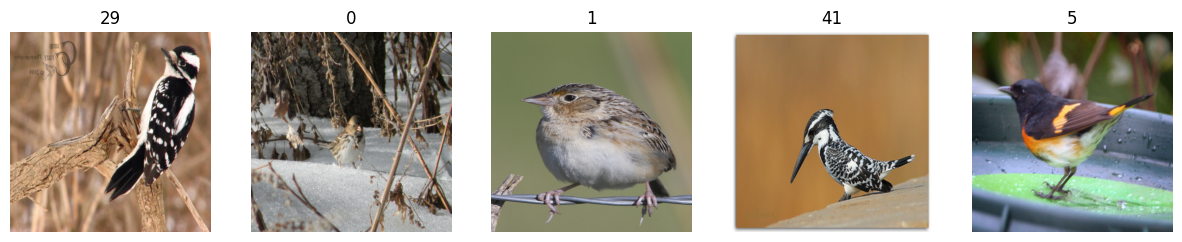

Epoch 14
Train Loss: 0.0008, Validation Loss: 0.2178, Validation Accuracy: 94.93%

Train Epoch 15 [0/944]	Loss: 0.000396
Train Epoch 15 [30/944]	Loss: 0.000131
Train Epoch 15 [60/944]	Loss: 0.000437
Train Epoch 15 [90/944]	Loss: 0.000370
Train Epoch 15 [120/944]	Loss: 0.000408
Train Epoch 15 [150/944]	Loss: 0.007290
Train Epoch 15 [180/944]	Loss: 0.000195
Train Epoch 15 [210/944]	Loss: 0.001601
Train Epoch 15 [240/944]	Loss: 0.001887
Train Epoch 15 [270/944]	Loss: 0.000741
Train Epoch 15 [300/944]	Loss: 0.000119
Train Epoch 15 [330/944]	Loss: 0.003517
Train Epoch 15 [360/944]	Loss: 0.000053
Train Epoch 15 [390/944]	Loss: 0.000351
Train Epoch 15 [420/944]	Loss: 0.000114
Train Epoch 15 [450/944]	Loss: 0.000125
Train Epoch 15 [480/944]	Loss: 0.001150
Train Epoch 15 [510/944]	Loss: 0.000729
Train Epoch 15 [540/944]	Loss: 0.000697
Train Epoch 15 [570/944]	Loss: 0.000089
Train Epoch 15 [600/944]	Loss: 0.012880
Train Epoch 15 [630/944]	Loss: 0.000201
Train Epoch 15 [660/944]	Loss: 0.000017
Tr

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f931653398d9>", line 10, in <cell line: 8>
    train_loss = train(model, train_loader, optimizer, epoch)
  File "<ipython-input-10-abfdd645824e>", line 4, in train
    for i, (image, target) in enumerate(train_loader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", l

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f931653398d9>", line 10, in <cell line: 8>
    train_loss = train(model, train_loader, optimizer, epoch)
  File "<ipython-input-10-abfdd645824e>", line 4, in train
    for i, (image, target) in enumerate(train_loader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

In [ ]:
### Main ###
start = time.time()
best = 0

### wandb ###
wandb.watch(model, log="all")

for epoch in range(EPOCH):
    # With Augmentation
    train_loss = train(model, train_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)

    # Save best model
    if val_accuracy > best:
        best = val_accuracy
        torch.save(model.state_dict(), "./best_model.pth")

    # augmentation 적용한 이미지 보기
    dataiter = iter(train_loader)
    images, labels = dataiter.__next__()
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
      image = images[i].numpy().transpose((1, 2, 0))
      image = np.clip(image, 0, 1)
      axes[i].imshow(image)
      axes[i].set_title(labels[i].item())
      axes[i].axis('off')
    plt.show()

    # Logging for model without augmentation
    wandb.log({
        'train_loss_with_aug': train_loss.item(),
        'val_loss_with_aug': val_loss,
        'val_accuracy_with_aug': val_accuracy,
    })

    print(f'Epoch {epoch}')
    print(f"Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("")

# Test results
test_loss, test_accuracy = evaluate(model, test_loader)

wandb.log({'test_accuracy_with_aug': test_accuracy})

print(f'[FINAL with Augmentation] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start
print(f"Best Accuracy: {best:.2f}%")
print(f"Elapsed Time: {int(elasped_time/3600)}h, {int((elasped_time%3600)/60)}m, {int(elasped_time%60)}s")
print(f"time: {int (elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

In [ ]:
torch.save(model.state_dict(), "./model_state_dict.pt")

In [ ]:
!pip install grad-cam

In [ ]:
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt
"""
model = model_
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 50)
model = model.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=lr)

model.load_state_dict(torch.load("model_state_dict.pt"))
model.eval()
"""

test_loss, test_accuracy = evaluate(model, test_loader)


print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')


def gradCAM_func(num):
  image_tensor, label = combined_train_set[num]
  transform = T.ToPILImage()
  rgb_img = transform(image_tensor)
  target_layers = [model.layer4[-1]]
  # Max min normalization
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
  # Create an input tensor image for your model
  input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
  # Note: input_tensor can be a batch tensor with several images!

  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

  grayscale_cam = cam(input_tensor=input_tensor)

  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  Image.fromarray(visualization, 'RGB')
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))

  # Display the image using imshow
  ax[0].imshow(rgb_img)
  ax[1].imshow(visualization)

  # Show the plot
  plt.title(label)
  plt.show()

  # Image.fromarray(visualization, 'RGB')

# 괄호 안에 아무 수나 넣고 테스트하면 됩니다.
for i in range(200):
  if i % 10 == 0:
    gradCAM_func(i)